In [1]:
from agents.dpm_agent import Agent
from trading_env.environment import TradingEnv

In [2]:
import dill
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [3]:
yf_file = "./data/archive_data/yf_data.dill"
with open(yf_file,'rb') as dill_file:
    yf_df = dill.load(dill_file)
    

In [4]:
print('Head of data set:')
yf_df.head()
print('Tail of data set:')
yf_df.tail()

Head of data set:
Tail of data set:


,Date,Symbol,high,low,open,close,volume,adjclose
110959,2020-12-24,WMT,144.389999,143.179993,143.539993,143.500000,3018200,142.344345
110960,2020-12-28,WMT,145.300003,143.330002,144.039993,145.220001,6448300,144.050491
110961,2020-12-29,WMT,145.850006,143.589996,145.639999,144.300003,5979400,143.137909
110962,2020-12-30,WMT,145.149994,143.940002,144.880005,144.179993,6250400,143.018860
110963,2020-12-31,WMT,144.270004,142.850006,144.199997,144.149994,5938000,142.989090


In [5]:
# Generate array of symbols in the yf dataframe
symbols = yf_df['Symbol'].unique()

# Create empty lists to gather data
training_data = []
training_start = '2000-1-1'
training_end = '2016-12-31'
training_mask = (yf_df['Date'] >= training_start) & (yf_df['Date'] <= training_end)
validation_data = []
validation_start = '2017-1-1'
validation_end = '2018-12-31'
validation_mask = (yf_df['Date'] >= validation_start) & (yf_df['Date'] <= validation_end)
test_data = []
test_start = '2019-1-1'
test_end = '2020-12-31'
test_mask = (yf_df['Date'] >= test_start) & (yf_df['Date'] <= test_end)

for symbol in symbols:
    # Select stock data for each symbol,
    # partition into training, validation, or test set
    df_train = yf_df[(yf_df['Symbol'] == symbol) & training_mask]
    df_validation = yf_df[(yf_df['Symbol'] == symbol) & validation_mask]
    df_test = yf_df[(yf_df['Symbol'] == symbol) & test_mask]
    
    # Select only high, low, open, and close prices for each stock
    training_data.append(df_train.iloc[:,2:6].to_numpy())
    validation_data.append(df_validation.iloc[:,2:6].to_numpy())
    test_data.append(df_test.iloc[:,2:6].to_numpy())
     
# Convert data to numpy arrays
training_data = np.array(training_data)
validation_data = np.array(validation_data)
test_data = np.array(test_data)

# Save the test data for post training
with open('test_data.dill','wb') as dill_file:
    dill.dump(test_data,dill_file)


In [6]:
training_data.shape

(21, 4277, 4)

In [7]:
# Batch the data
data_len = training_data.shape[1]
div = list(map(int,np.linspace(0,data_len,41)))
batched_training_data = np.split(training_data,div[1:-1],axis=1)


In [8]:
# Create DPM agent for training
n_stocks = training_data.shape[0]
n_stock_feats = training_data.shape[2]

agent = Agent(n_stocks,n_stock_feats)

Untrained portfolio:


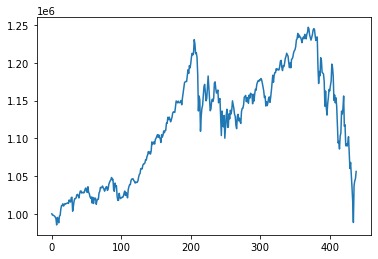

In [9]:
env = TradingEnv(validation_data)
obs = env.reset()
done = False
last_raw_action = tf.zeros((1,n_stocks+1))
while not done:
    raw_action = agent.act(obs,last_raw_action) 
    obs, reward, done, _ = env.step(agent.model.softmax_layer(raw_action))
    last_raw_action = raw_action 
print('Untrained portfolio:') 
plt.plot(env.portfolio_value_hist)
plt.show()


In [10]:
batched_training_data[0].shape

(21, 106, 4)

In [11]:
def loss_val(stock_data):
    total_loss = tf.convert_to_tensor(0.0)
    env = TradingEnv(stock_data)
    obs = env.reset()
    done = False
    last_raw_action = tf.zeros((1,n_stocks+1))
    while not done:

        raw_action=agent.act(obs,last_raw_action)
        obs,reward,done,_=env.step(agent.model.softmax_layer(raw_action))
        last_raw_action=raw_action
        total_loss-=reward

    return total_loss, env



In [12]:
import datetime
time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
validation_log_dir = 'logs/grad_tape/'+time+'/valid'
validation_summary_writer = tf.summary.create_file_writer(validation_log_dir)

tf.Tensor(1278397.1, shape=(), dtype=float32)
tf.Tensor(1319303.0, shape=(), dtype=float32)
tf.Tensor(1324304.9, shape=(), dtype=float32)
tf.Tensor(1325932.1, shape=(), dtype=float32)
tf.Tensor(1327558.9, shape=(), dtype=float32)
Trained portfolio:


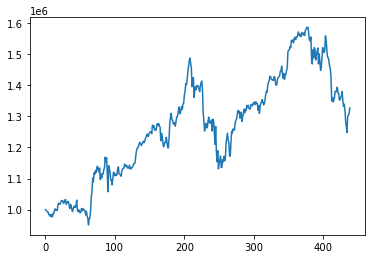

In [13]:
validation_loss = tf.keras.metrics.Mean('validation_loss', dtype=tf.float32)
EPOCHS = 5

for epoch in range(EPOCHS):

    for batch in batched_training_data:
        # Train on current batch
        with tf.GradientTape() as tape:
            tape.watch(agent.model.trainable_variables)
            loss, env = loss_val(batch)
        grad = tape.gradient(loss,agent.model.trainable_variables)
        grad = [g / tf.reduce_mean(tf.abs(g)) for g in grad]
        agent.opt.apply_gradients(zip(grad,agent.model.trainable_variables))

    # Evaluate performance on validation set:
    loss,env = loss_val(validation_data)
    print(env.portfolio_value_hist[-1])
    validation_loss(loss)
    with validation_summary_writer.as_default():
        tf.summary.scalar('loss',validation_loss.result(),step = epoch)

print('Trained portfolio:') 
plt.plot(env.portfolio_value_hist)
plt.show()

In [14]:
#%load_ext tensorboard
#%tensorboard  --logdir logs/grad_tape/